# Debugging LSTM Predictor Flow

In [1]:
import os
import torch
import lib.visualizations as visualizations
from lib.config import Config
from models.model_utils import freeze_params
import data as datalib

trainer = __import__('04_train_slot_prediction_lstm')

/home/user/villar/anaconda3/envs/VideoPred/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
name_predictor_experiment = "lstm"
exp_path = "/home/user/villar/ObjectCentricVideoPred/experiments/exps_ismail/Obj3d-constant-lr"
sa_check = "checkpoint_epoch_final.pth"
pred_check = "checkpoint_epoch_1400.pth"

## Setting Up

In [4]:
T = trainer.Trainer(
        name_predictor_experiment=name_predictor_experiment,
        exp_path=exp_path,
        sa_model_directory=sa_check,
        checkpoint=pred_check
    )

In [5]:
T.load_data()
T.load_model()
T.setup_predictor()
T.setup_predictor()

Examples in training set: 2920
Examples in validation set: 200
False
Decoder:
  --> Resolution=[64, 64]
  --> Num channelsl=[32, 32, 32, 32]
  --> Upsample=4
  --> Downsample_encoder=False
  --> Decoder_resolution=[64, 64]
resolution: [64, 64] , hidden_size: 32
resolution: [64, 64] , hidden_size: 64
Setting up Constant LR-Scheduler:
   Factor:   0.8
   total_iters: 1000000.0
Not using learning rate warmup...
creating loss function of type: pred_img_mse
creating loss function of type: pred_slot_mse
Loading pretrained parameters from checkpoint checkpoint_epoch_1400.pth...
Setting up Constant LR-Scheduler:
   Factor:   0.8
   total_iters: 1000000.0
Not using learning rate warmup...
creating loss function of type: pred_img_mse
creating loss function of type: pred_slot_mse
Loading pretrained parameters from checkpoint checkpoint_epoch_1400.pth...


## Forward Pass Flow

In [6]:
# parameters
num_context = T.exp_params["training_prediction"]["num_context"]
num_preds = T.exp_params["training_prediction"]["num_preds"]
num_slots = T.model.num_slots
slot_dim = T.model.slot_dim
video_length = T.exp_params["training_prediction"]["sample_length"]

videos = next(iter(T.valid_loader))
videos = videos.to(T.device)
B, L, C, H, W = videos.shape

In [7]:
# computing slots with pretrained SAVI  
with torch.no_grad():
    slot_history, reconstruction_history, individual_recons_history, masks_history = T.model(videos, num_imgs = video_length )
    
# slot_history ~ (B, L, num_slots, slot_dim). Therefore, permuting is necessary
slot_history_lstm_input = slot_history.permute(0, 2, 1, 3).reshape(B * num_slots, L, slot_dim)
# NOTE: Before it was: `slot_history_lstm_input = slot_history.reshape(B * num_slots, L, slot_dim)`

In [9]:
# using seed images to initialize the RNN predictor
pred_slots = []
T.predictor.init_hidden(b_size=B * num_slots, device=T.device)
for t in range(num_context-1):
    _ = T.predictor(slot_history_lstm_input[:, t])

# Autoregressively predicting the future slots
next_input = slot_history_lstm_input[:, num_context-1]
for t in range(num_preds):
    cur_preds = T.predictor(next_input)
    # NOTE: I made some changes here, there was some issue with reshaping and so on
    next_input = cur_preds  # no teacher forcing at validation/test
    pred_slots.append(cur_preds)
pred_slots = torch.stack(pred_slots, dim=1)  # (B*num_slots, num_preds, slot_dim)

pred_slots = pred_slots.reshape(B, num_slots, num_preds, slot_dim).permute(0, 2, 1, 3)

In [10]:
# decoding predicted slots into predicted frames
pred_slots_decode = pred_slots.clone().reshape(B * num_preds, num_slots, slot_dim)
img_recons, (pred_recons, pred_masks) = T.model.decode(pred_slots_decode)
pred_imgs = img_recons.view(B, num_preds, C, H, W)

# computing loss for all predicted slots
seed_imgs = videos[:, :num_context, :, :]
target_slots = slot_history[:, num_context:num_context+num_preds, :, :]
target_imgs = videos[:, num_context:num_context+num_preds, :, :]

## Visualizations

 - **Green:** Ground Truth frame or object
 - **Red:** Predicted frame or object

In [19]:
BATCH_ID = 63

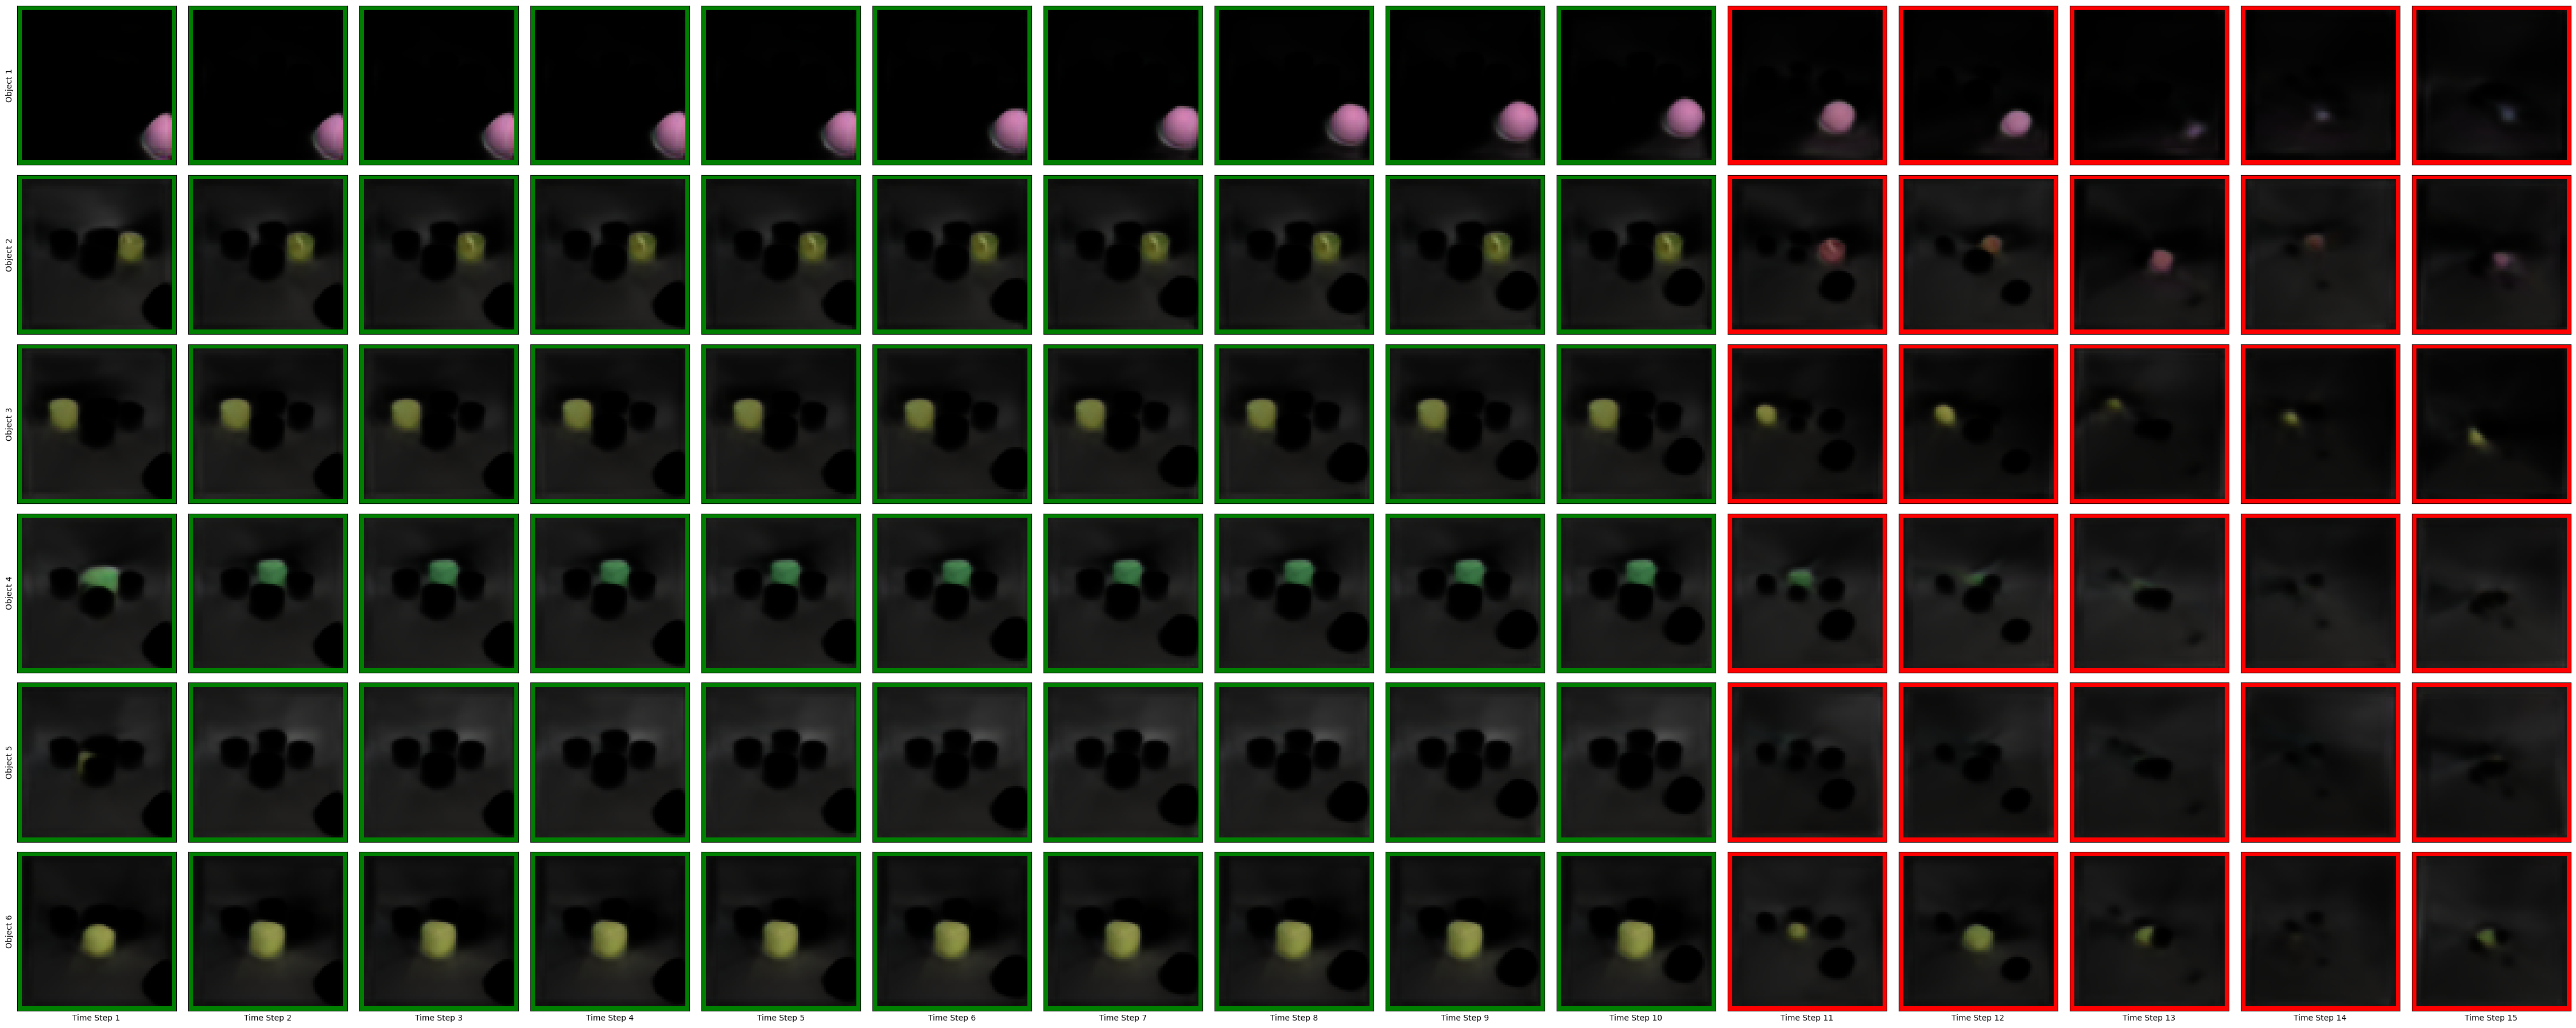

In [20]:
seed_objs = visualizations.add_border(individual_recons_history * masks_history, color_name="green", pad=2)
pred_objs = visualizations.add_border(pred_recons * pred_masks, color_name="red", pad=2)
pred_objs = pred_objs.reshape(B, num_preds, num_slots, *pred_objs.shape[-3:])
all_obs = torch.cat([seed_objs, pred_objs], dim=1)

_ = visualizations.visualize_aligned_slots(all_obs[BATCH_ID])

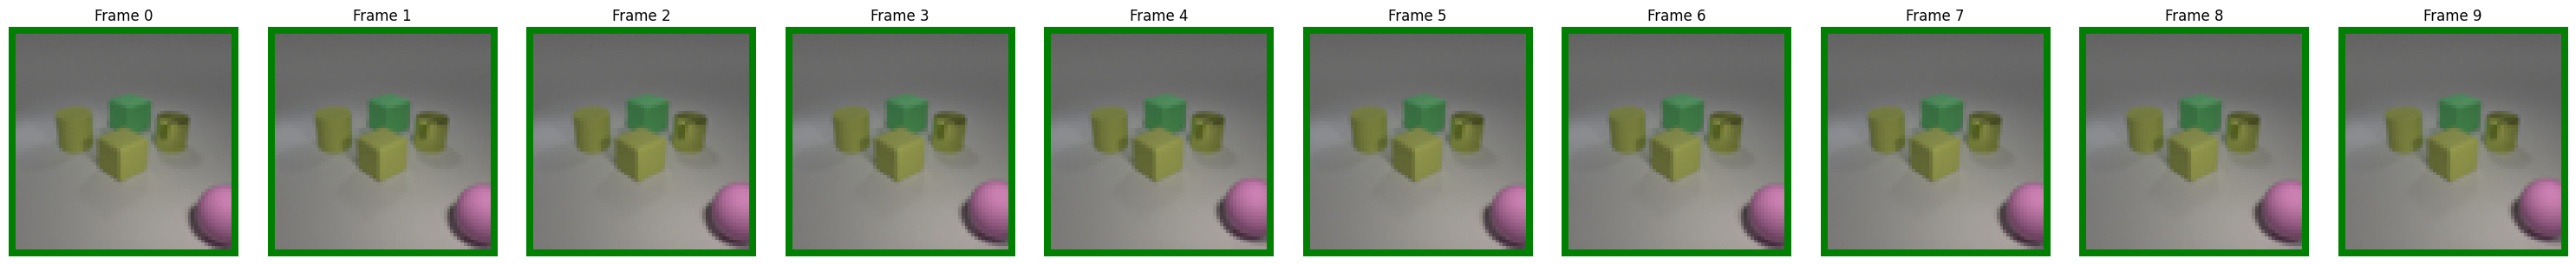

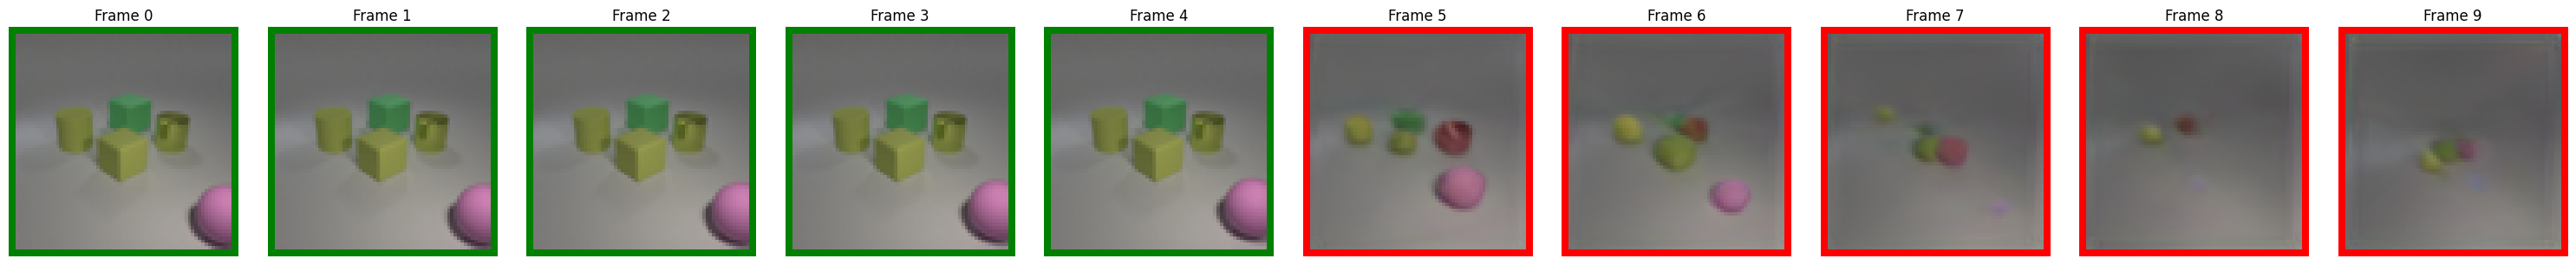

In [21]:
seed_disp = visualizations.add_border(seed_imgs, "green", 2)
target_disp = visualizations.add_border(seed_imgs, "green", 2)
pred_disp = visualizations.add_border(pred_imgs, "red", 2)
gt_disp = torch.cat([seed_disp, target_disp], dim=1)
pred_disp = torch.cat([seed_disp, pred_disp], dim=1)

_ = visualizations.visualize_sequence(gt_disp[BATCH_ID], n_cols=10) 
_ = visualizations.visualize_sequence(pred_disp[BATCH_ID], n_cols=10)

<a style="font-size: 1.4em">
The visualizations above are not great, but they seem more temporally consistent than what you sent yesterday.<br>
Maybe it works now, but since the LSTM has been trained with a bug in the forward pass, the learned parameters are not too useful.
</a>